In [1]:
import numpy as np
import matplotlib.pyplot as plt
from src.data_util import load_augmented_example, load_preprocess_examples
from src.evaluation import DAP_SAP_MAP_kde, hist_AP, plot_SAP_MAP

import tensorflow as tf

from sklearn.model_selection import train_test_split
import glob
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import seaborn as sns
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

np.random.seed(42)
tf.random.set_seed(42)

2024-12-19 11:13:12.451590: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-19 11:13:13.098021: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
all_pigs = ["P_{0:02d}_PulHyp".format(i) for i in range(1, 11)]
print(all_pigs)

pig_test_s_dict = {
    "P_01_PulHyp": 10338,
    "P_02_PulHyp": 12859,
    "P_03_PulHyp": 8124,
    "P_04_PulHyp": 8914,
    "P_05_PulHyp": 10063,
    "P_06_PulHyp": 6934,
    "P_07_PulHyp": 5692,
    "P_08_PulHyp": 7189,
    "P_09_PulHyp": 8228,
    "P_10_PulHyp": 6552,
}

load_path = "/data/PulHypStudie_Check_npz_v4_SNR20/"

['P_01_PulHyp', 'P_02_PulHyp', 'P_03_PulHyp', 'P_04_PulHyp', 'P_05_PulHyp', 'P_06_PulHyp', 'P_07_PulHyp', 'P_08_PulHyp', 'P_09_PulHyp', 'P_10_PulHyp']


In [3]:
X_train, y_train, clrs_pig_train = load_augmented_example(
    load_path, all_pigs, sample_skip=500, load_samples="upwards", shuffle=True
)

X_valid, y_valid, clrs_pig_valid = load_augmented_example(
    load_path, all_pigs, sample_skip=500, load_samples="downwards", shuffle=True
)

Selected 14500 from /data/PulHypStudie_Check_npz_v4_SNR20/P_01_PulHyp/sample_000500.npz to /data/PulHypStudie_Check_npz_v4_SNR20/P_01_PulHyp/sample_014999.npz from pig P_01_PulHyp.
Selected 14500 from /data/PulHypStudie_Check_npz_v4_SNR20/P_02_PulHyp/sample_000500.npz to /data/PulHypStudie_Check_npz_v4_SNR20/P_02_PulHyp/sample_014999.npz from pig P_02_PulHyp.
Selected 14500 from /data/PulHypStudie_Check_npz_v4_SNR20/P_03_PulHyp/sample_000500.npz to /data/PulHypStudie_Check_npz_v4_SNR20/P_03_PulHyp/sample_014999.npz from pig P_03_PulHyp.
Selected 14500 from /data/PulHypStudie_Check_npz_v4_SNR20/P_04_PulHyp/sample_000500.npz to /data/PulHypStudie_Check_npz_v4_SNR20/P_04_PulHyp/sample_014999.npz from pig P_04_PulHyp.
Selected 14500 from /data/PulHypStudie_Check_npz_v4_SNR20/P_05_PulHyp/sample_000500.npz to /data/PulHypStudie_Check_npz_v4_SNR20/P_05_PulHyp/sample_014999.npz from pig P_05_PulHyp.
Selected 14500 from /data/PulHypStudie_Check_npz_v4_SNR20/P_06_PulHyp/sample_000500.npz to /dat

In [19]:
print(
    X_train.shape,
    X_valid.shape,
    y_train.shape,
    y_valid.shape,
    clrs_pig_train.shape,
    clrs_pig_valid.shape,
)

(145000, 64, 1024, 1) (5000, 64, 1024, 1) (145000, 3) (5000, 3) (145000, 3) (5000, 3)


In [5]:
np.max(y_train, axis=0),np.max(y_valid, axis=0)

(array([119.11916351, 179.35577393, 146.35994611]),
 array([ 97.0679903 , 144.69028186, 122.57101606]))

In [6]:
dap_factor = 120
sap_factor = 180
map_factor = 150

y_train[:, 0] = y_train[:, 0] / dap_factor  # dap normalization
y_train[:, 1] = y_train[:, 1] / sap_factor  # sap normalization
y_train[:, 2] = y_train[:, 2] / map_factor  # map normalization

y_valid[:, 0] = y_valid[:, 0] / dap_factor  # dap normalization
y_valid[:, 1] = y_valid[:, 1] / sap_factor  # sap normalization
y_valid[:, 2] = y_valid[:, 2] / map_factor  # map normalization

In [20]:
np.max(y_train, axis=0),np.max(y_valid, axis=0)

(array([0.9926597 , 0.99642097, 0.97573297]),
 array([0.80889992, 0.8038349 , 0.81714011]))

**Get test pig**

In [21]:
for p_n, drop_pig in enumerate(all_pigs):
    print(f"Tuning for all pics and test on {drop_pig}")
    upw_num = pig_test_s_dict[drop_pig]
    print("Test smples:", upw_num)

Tuning for all pics and test on P_01_PulHyp
Test smples: 10338
Tuning for all pics and test on P_02_PulHyp
Test smples: 12859
Tuning for all pics and test on P_03_PulHyp
Test smples: 8124
Tuning for all pics and test on P_04_PulHyp
Test smples: 8914
Tuning for all pics and test on P_05_PulHyp
Test smples: 10063
Tuning for all pics and test on P_06_PulHyp
Test smples: 6934
Tuning for all pics and test on P_07_PulHyp
Test smples: 5692
Tuning for all pics and test on P_08_PulHyp
Test smples: 7189
Tuning for all pics and test on P_09_PulHyp
Test smples: 8228
Tuning for all pics and test on P_10_PulHyp
Test smples: 6552


In [41]:
tmp = np.load("/data/PulHypStudie_Check_npz_v4_SNR20/P_01_PulHyp/sample_014999.npz", allow_pickle=True)
tmp.files

['eit', 'y', 'pig']

In [42]:
tmp["pig"]

array(['Pig_01', 'block_06', 'PulHyp'], dtype='<U8')

(array([14358., 14667., 14529., 14598., 14395., 14791., 14295., 14289.,
        14550., 14528.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

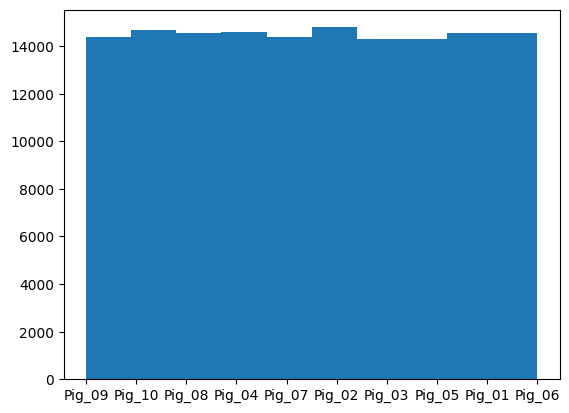

In [22]:
plt.hist(clrs_pig_train[:,0])

In [9]:
def find_pig_indices(pig_list : list, filt_for:str, mode="only"):
    pig_list = pig_list[:,0]
    if mode == "only":
        idx = np.where(pig_list == filt_for)[0]
    if mode == "exclude":
        idx = np.where(pig_list != filt_for)[0]

    print(f"Found {len(idx)} entries.")
    return idx

In [25]:
find_pig_indices(clrs_pig_train, filt_for="Pig_02")

Found 14791 entries.


array([    10,     47,     52, ..., 144962, 144977, 144983])

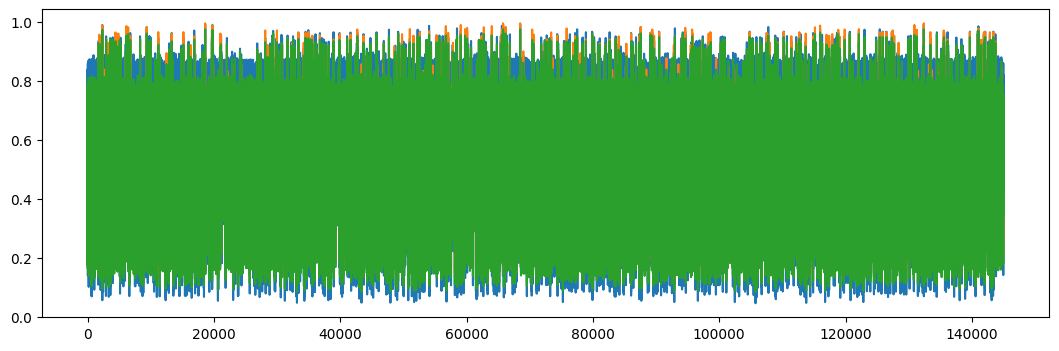

In [10]:
plt.figure(figsize=(13,4))
plt.plot(y_train[:,0])
plt.plot(y_train[:,1])
plt.plot(y_train[:,2])

In [15]:
np.unique(clrs_pig_p1[:,0])

array(['Pig_05'], dtype='<U8')

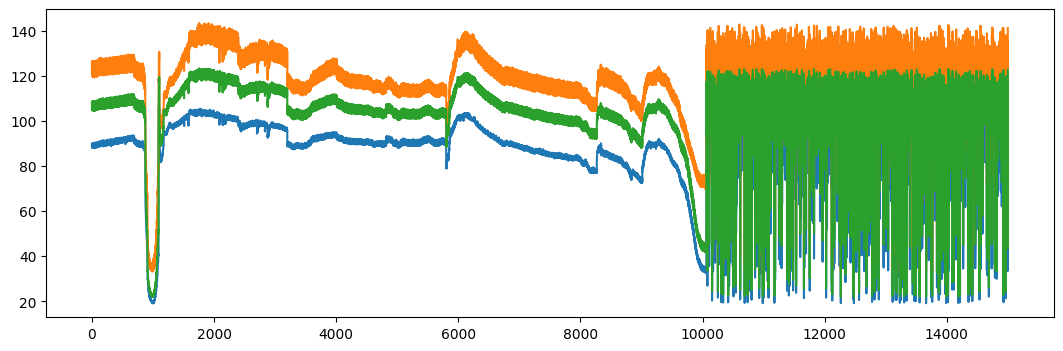

In [12]:
plt.figure(figsize=(13,4))
plt.plot(y_p1[:,0])
plt.plot(y_p1[:,1])
plt.plot(y_p1[:,2])

In [25]:
clrs_pig_train

array([['Pig_09', 'block_06', 'PulHyp'],
       ['Pig_10', 'block_03', 'PulHyp'],
       ['Pig_08', 'block_05', 'PulHyp'],
       ...,
       ['Pig_07', 'block_05', 'PulHyp'],
       ['Pig_05', 'block_07', 'PulHyp'],
       ['Pig_06', 'block_07', 'PulHyp']], dtype='<U8')

In [ ]:
X_test, y_test, clrs_pig_test = load_augmented_example(
    load_path, pigs, sample_skip=upw_num, load_samples="downwards", shuffle=True
)

In [4]:
print(
    X_train.shape,
    y_train.shape,
    clrs_pig_train.shape,
)

(150000, 64, 1024, 1) (150000, 3) (150000, 3)


In [5]:
np.max(y_train, axis=0)

array([119.11916351, 179.41304016, 146.35994611])

In [6]:
dap_factor = 120
sap_factor = 180
map_factor = 150

y_train[:, 0] = y_train[:, 0] / dap_factor  # dap normalization
y_train[:, 1] = y_train[:, 1] / sap_factor  # sap normalization
y_train[:, 2] = y_train[:, 2] / map_factor  # map normalization

In [8]:
np.max(y_train, axis=0)

array([0.9926597 , 0.99673911, 0.97573297])

**Drop Pig function**

In [17]:
for p_n, drop_pig in enumerate(all_pigs):
    print(f"Tuning for all pics and test on {drop_pig}")
    # select train/test indices
    train_sel = find_pig_indices(clrs_pig_train, filt_for=f"Pig_0{p_n+1}",mode="exclude")

# tbd:
    # load only test pig non shuffled

X_test, y_test, clrs_pig_test = load_augmented_example(
    load_path, pigs, sample_skip=0, load_samples="upwards", shuffle=False
)


Tuning for all pics and test on P_01_PulHyp
Found 134956 entries.
Found 15044 entries.
Tuning for all pics and test on P_02_PulHyp
Found 134657 entries.
Found 15343 entries.
Tuning for all pics and test on P_03_PulHyp
Found 135281 entries.
Found 14719 entries.
Tuning for all pics and test on P_04_PulHyp
Found 134892 entries.
Found 15108 entries.
Tuning for all pics and test on P_05_PulHyp
Found 135240 entries.
Found 14760 entries.
Tuning for all pics and test on P_06_PulHyp
Found 134882 entries.
Found 15118 entries.
Tuning for all pics and test on P_07_PulHyp
Found 135096 entries.
Found 14904 entries.
Tuning for all pics and test on P_08_PulHyp
Found 135079 entries.
Found 14921 entries.
Tuning for all pics and test on P_09_PulHyp
Found 135063 entries.
Found 14937 entries.
Tuning for all pics and test on P_10_PulHyp
Found 150000 entries.
Found 0 entries.
